<a href="https://colab.research.google.com/github/Jin-jin-jara/hello-world/blob/master/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN을 이용한 이상치 탐지

### 이상치 탐지란?

이상치는 신용카드 사기, 공장의 불량품 같은 데이터의 비정상적인 패턴을 뜻합니다. 이상치 탐지란 말 그대로 이상(문제)이 있는 데이터를 탐지해내는 것입니다.실생활에서 이러한 위협 또는 고장으로 발생하는 피해를 방지하기 위해 이상 탐지는 필수적으로 해결해야 할 문제입니다. 이상한 패턴을 가지고 있는 데이터들을 사람이 일일이 확인하는 것이 아니라 기계가 찾아줄 수 있다면 다양한 분야에서 유용하게 쓰일 수 있을 것입니다.

### GAN(Generative Adversarial Network)이란?

처음 GAN을 제안한 Ian Goodfellow는 GAN을 경찰과 위조지폐범 사이의 게임에 비유했습니다. 위조지폐범은 최대한 진짜 같은 화폐를 만들어(생성) 경찰을 속이기 위해 노력하고, 경찰은 진짜 화폐와 가짜 화폐를 완벽히 판별(분류)하여 위조지폐범을 검거하는 것을 목표로 합니다. 이러한 경쟁적인 학습이 지속되다 보면 어느 순간 위조지폐범은 진짜와 다를 바 없는 위조지폐를 만들 수 있게 되고 경찰이 위조지폐를 구별할 수 있는 확률도 가장 헷갈리는 50%로 수렴하게 되어 경찰은 위조지폐와 실제 화폐를 구분할 수 없는 상태에 이르게 됩니다.<br><br> 여기서 경찰은 분류 모델, 위조지폐범은 생성 모델을 의미하며, GAN에는 최대한 진짜 같은 데이터를 생성하려는 생성 모델과 진짜와 가짜를 판별하려는 분류 모델이 각각 존재하여 서로 적대적으로 학습합니다.

<img src="http://mrkim.cloudy.so/files/attach/images/146/378/175/feb74723d68b2698268de9f6cae3ac9b.PNG" align='center'>

생성 모델에서 만들어낸 가짜 데이터를 판별 모델에 입력하고, 가짜 데이터를 진짜라고 분류할 만큼 진짜 데이터와 유사한 데이터를 만들어 내도록 생성 모델을 학습시킵니다. 적대적 학습이 완료되었을 때 위조지폐범은 진짜 같은 위조지폐를 만들 것이고 경찰은 누구보다 뛰어난 위조지폐 감별사가 되어있을 것입니다. 이번 프로젝트에서는 위조지폐범(생성 모델)이 아닌 경찰(감별 모델)의 힘을 빌려보고자 합니다.<br><br>
정상적이지 않은 데이터를 생성해 적대적으로 학습된 감별 모델에 넣어보겠습니다. 잘 훈련된 감별 모델이라면 정상인 데이터에 대해서는 1에 가까운 값을, 비정상인 데이터에 대해서는 0에 가까운 값을 출력할 것입니다.

### 필요 라이브러리 불러오기

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

TensorFlow 2.x selected.


In [2]:
tf.__version__

'2.1.0'

In [0]:
!pip install -q imageio

### MNIST 데이터셋

생성자와 감별자를 훈련하기위해 MNIST 손글씨 숫자 데이터셋을 사용하겠습니다. 생성자는 손글씨 숫자 데이터를 닮은 숫자들을 생성할 것입니다.

#### 정상 데이터셋

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# 이미지의 범위를 [-1, 1] 사이로 정규화합니다.
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


Text(0.5, 1.0, '5')

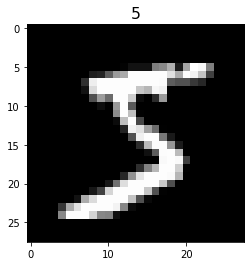

In [5]:
plt.imshow(train_images[0].reshape((28, 28)), cmap='gray')
plt.rc('font', size=13)
plt.title(train_labels[0])

In [6]:
a =  random.randrange(1,4)
a

3

#### 비정상 데이터셋(이상치)

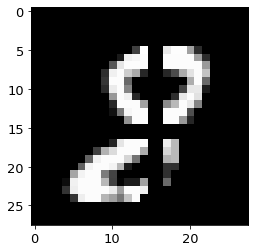

In [7]:
def make_noise_images(noise_type= random.randrange(1,4)):
  noise_images = np.array(random.sample(list(train_images), 1000))

  # 이미지에 수평선을 긋습니다
  if noise_type==1:
    noise_images[:, 15:17, :, :] = -1
  
  # 이미지에 수직선을 긋습니다.
  elif noise_type==2:
    noise_images[:, :, 15:17, :] = -1

  # 이미지에 십자가를 긋습니다.
  elif noise_type==3:
    noise_images[:, 15:17, :, :] = -1
    noise_images[:, :, 15:17, :] = -1

  return noise_images

noise_images = make_noise_images()
plt.imshow(noise_images[0].reshape((28, 28)), cmap='gray')

### 모델

#### 생성자(Generator)

생성자는 시드값 (seed; 랜덤한 잡음)으로부터 이미지를 생성하기 위해, tf.keras.layers.Conv2DTranspose (업샘플링) 층을 이용합니다. 처음 Dense층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 tf.keras.layers.LeakyReLU을 사용했습니다.

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

(아직 훈련이 되지않은) 생성자를 이용해 이미지를 생성해보겠습니다.

Text(0.5, 1.0, 'Generated Image Before Train')

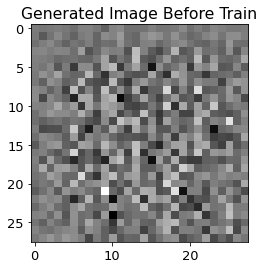

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title("Generated Image Before Train")

#### 감별자(Discriminator)

감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다.

In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

(아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 모델은 진짜 이미지에는 1을, 가짜 이미지에는 0을 출력하도록 훈련될 것입니다.

In [0]:
def sigmoid(x):
    return 1 / (1 +np.exp(-x))

In [12]:
discriminator = make_discriminator_model()
decision = sigmoid(discriminator(generated_image))
print(decision)

[[0.49969643]]


### Loss function, Optimizer

두 모델의 손실함수와 옵티마이저를 정의합니다.

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### 감별자 손실함수

이 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#### 생성자 손실함수

생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교를 할 것입니다.

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 다릅니다.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 훈련 루프 정의

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

훈련 루프는 생성자가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트합니다.

In [0]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  print(type(gradients_of_discriminator))
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
  
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

이미지 생성 및 저장

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.show()

감별자가 훈련되기 전에는 감별자는 비정상 이미지에 대해 거의 감별을 해내지 못합니다. 감별자의 출력값은 대부분 0.5주변에 몰려있습니다.

Text(0.5, 1.0, 'Noise images before train')

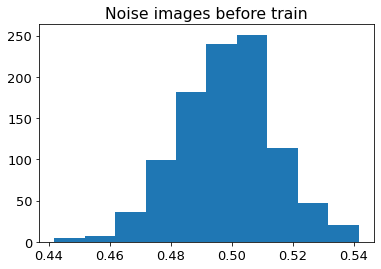

In [21]:
disc_noise = sigmoid(discriminator(noise_images, training=False))
plt.hist(disc_noise)
plt.title("Noise images before train")

위에 정의된 train() 메서드를 생성자와 감별자를 동시에 훈련하기 위해 호출합니다. 훈련 초반부에는 생성된 이미지는 랜덤한 노이즈처럼 보입니다. 훈련이 진행될수록, 생성된 숫자들이 진짜처럼 보입니다. 이 프로젝트에서는 훈련 시간이 너무 오래걸리기 때문에 50번만 진행하겠습니다. 훈련 횟수를 늘리면 점점 실제 숫자 이미지와 비슷해져갑니다.

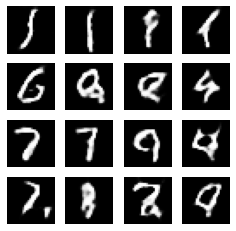

In [22]:
train(train_dataset, EPOCHS)

훈련을 진행할 수록 감별자는 MNIST 데이터 셋에 대한 전문 감별사가 됩니다. 훈련 전과는 다르게 비정상 데이터에 대한 감별자의 출력값이 1보단 0에 가까운 값을 가집니다. 

Text(0.5, 1.0, 'Noise images after train(epoch = 50)')

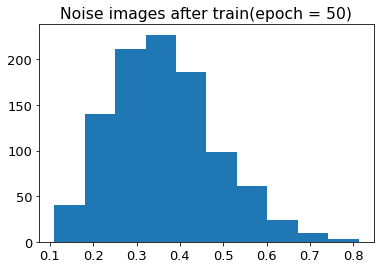

In [23]:
disc_noise = sigmoid(discriminator(noise_images, training=False))
plt.hist(disc_noise)
plt.title("Noise images after train(epoch = 50)")

훈련된 감별자로 비정상 데이터를 탐지하는 이상치 탐지기를 만들어보겠습니다.

In [0]:
# 감별자를 이용해 이미지의 이상치를 탐지하는 함수
def anomaly_detector(dataset):
  normal = []
  anomalies = []
  for img in dataset:
    img = img.reshape(1,28,28,1)
    predict = sigmoid(discriminator(img,training=False))
    if predict > 0.5:
      normal.append(img)
    else:
      anomalies.append(img)
  return len(normal)/len(dataset) , len(anomalies)/len(dataset)

In [25]:
normal_img = np.array(random.sample(list(train_images), 100))
anomaly_img = np.array(random.sample(list(noise_images), 100))

print("정상 이미지에 대한 정확도: {}".format(anomaly_detector(normal_img)[0]))
print("비정상 이미지에 대한 정확도 : {}".format(anomaly_detector(anomaly_img)[1]))

정상 이미지에 대한 정확도: 0.78
비정상 이미지에 대한 정확도 : 0.88
